<a href="https://colab.research.google.com/github/NICFRU/Advance-Machine-Learning/blob/master/bonus4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tensflow 

In [ ]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(42)



In [ ]:
tf.random.set_seed(42)

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

In [ ]:
artists = pd.read_csv('/content/drive/MyDrive/Bonus 4/artists.csv')
artists.shape

(50, 8)

In [ ]:
artists.head()

|index|id|name|years|genre|nationality|bio|wikipedia|paintings|
|---|---|---|---|---|---|---|---|---|
|0|0|Amedeo Modigliani|1884 - 1920|Expressionism|Italian|Amedeo Clemente Modigliani \(Italian pronunciation: \[ameˈdɛːo modiʎˈʎaːni\]; 12 July 1884 – 24 January 1920\) was an Italian Jewish painter and sculptor who worked mainly in France\. He is known for portraits and nudes in a modern style characterized by elongation of faces, necks, and figures that were not received well during his lifetime but later found acceptance\. Modigliani spent his youth in Italy, where he studied the art of antiquity and the Renaissance\. In 1906 he moved to Paris, where he came into contact with such artists as Pablo Picasso and Constantin Brâncuși\. By 1912 Modigliani was exhibiting highly stylized sculptures with Cubists of the Section d'Or group at the Salon d'Automne\.|http://en\.wikipedia\.org/wiki/Amedeo\_Modigliani|193|
|1|1|Vasiliy Kandinskiy|1866 - 1944|Expressionism,Abstractionism|Russian|Wassily Wassilyevich Kandinsky \(Russian: Васи́лий Васи́льевич Канди́нский, tr\. Vasíliy Vasílʹevich Kandínskiy\) \(16 December \[O\.S\. 4 December\] 1866 – 13 December 1944\) was a Russian painter and art theorist\.|http://en\.wikipedia\.org/wiki/Wassily\_Kandinsky|88|
|2|2|Diego Rivera|1886 - 1957|Social Realism,Muralism|Mexican|Diego María de la Concepción Juan Nepomuceno Estanislao de la Rivera y Barrientos Acosta y Rodríguez, known as Diego Rivera \(Spanish pronunciation: \[ˈdjeɣo riˈβeɾa\]; December 8, 1886 – November 24, 1957\) was a prominent Mexican painter\. His large frescoes helped establish the Mexican mural movement in Mexican art\. Between 1922 and 1953, Rivera painted murals in, among other places, Mexico City, Chapingo, Cuernavaca, San Francisco, Detroit, and New York City\. In 1931, a retrospective exhibition of his works was held at the Museum of Modern Art in New York\. Rivera had a volatile marriage with fellow Mexican artist Frida Kahlo\.|http://en\.wikipedia\.org/wiki/Diego\_Rivera|70|
|3|3|Claude Monet|1840 - 1926|Impressionism|French|Oscar-Claude Monet \(; French: \[klod mɔnɛ\]; 14 November 1840 – 5 December 1926\) was a French painter, a founder of French Impressionist painting and the most consistent and prolific practitioner of the movement's philosophy of expressing one's perceptions before nature, especially as applied to plein air landscape painting\. The term "Impressionism" is derived from the title of his painting Impression, soleil levant \(Impression, Sunrise\), which was exhibited in 1874 in the first of the independent exhibitions mounted by Monet and his associates as an alternative to the Salon de Paris\.Monet's ambition of documenting the French countryside led him to adopt a method of painting the same scene many times in order to capture the changing of light and the passing of the seasons\. From 1883, Monet lived in Giverny, where he purchased a house and property and began a vast landscaping project which included lily ponds that would become the subjects of his best-known works\. In 1899, he began painting the water lilies, first in vertical views with a Japanese bridge as a central feature and later in the series of large-scale paintings that was to occupy him continuously for the next 20 years of his life\.|http://en\.wikipedia\.org/wiki/Claude\_Monet|73|
|4|4|Rene Magritte|1898 - 1967|Surrealism,Impressionism|Belgian|René François Ghislain Magritte \(French: \[ʁəne fʁɑ̃swa ɡilɛ̃ maɡʁit\]; 21 November 1898 – 15 August 1967\) was a Belgian Surrealist artist\. He became well known for creating a number of witty and thought-provoking images\. Often depicting ordinary objects in an unusual context, his work is known for challenging observers' preconditioned perceptions of reality\. His imagery has influenced Pop art, minimalist and conceptual art\.|http://en\.wikipedia\.org/wiki/René\_Magritte|194|

In [ ]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]
#artists_top['class_weight'] = max(artists_top.paintings)/artists_top.paintings
artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

|index|name|paintings|class\_weight|
|---|---|---|---|
|0|Vincent van Gogh|877|0\.44563076604125634|
|1|Edgar Degas|702|0\.5567210567210568|
|2|Pablo Picasso|439|0\.8902464278318493|
|3|Pierre-Auguste Renoir|336|1\.1631493506493507|
|4|Albrecht Dürer|328|1\.1915188470066518|
|5|Paul Gauguin|311|1\.2566501023092662|
|6|Francisco Goya|291|1\.3430178069353327|
|7|Rembrandt|262|1\.491672449687717|
|8|Alfred Sisley|259|1\.5089505089505089|
|9|Titian|255|1\.532620320855615|
|10|Marc Chagall|239|1\.6352225180677062|

In [ ]:
images_dir = '/content/drive/MyDrive/Bonus 4/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

In [ ]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   #rotation_range=45,
                                   #width_shift_range=0.5,
                                   #height_shift_range=0.5,
                                   shear_range=5,
                                   #zoom_range=0.7,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.

Found 855 images belonging to 11 classes.

Total number of batches = 215 and 53


In [ ]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

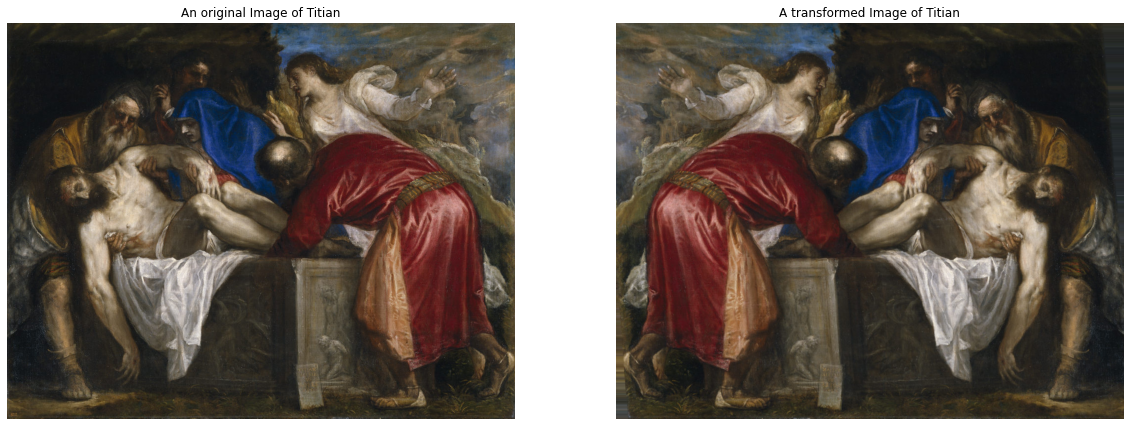

In [ ]:
# Load pre-trained model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=train_input_shape)



In [ ]:
for layer in base_model.layers:
    layer.trainable = True

In [ ]:
base_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
==================================================================================================
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 112, 112, 64  256         ['conv1_conv[0][0]']             
                                )                                                                 
                                                                                                  
 conv1_relu (Activation)        (None, 112, 112, 64  0           ['conv1_bn[0][0]']               
                                )                                                                 
                                                                                                  
 pool1_pad (ZeroPadding2D)      (None, 114, 114, 64  0           ['conv1_relu[0][0]']             
                                )                                                                 
                                                                                                  
 pool1_pool (MaxPooling2D)      (None, 56, 56, 64)   0           ['pool1_pad[0][0]']              
                                                                                                  
 conv2_block1_1_conv (Conv2D)   (None, 56, 56, 64)   4160        ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block1_1_relu[0][0]']    
                                                                                                  
 conv2_block1_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block1_0_conv (Conv2D)   (None, 56, 56, 256)  16640       ['pool1_pool[0][0]']             
                                                                                                  
 conv2_block1_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block1_2_relu[0][0]']    
                                                                                                  
 conv2_block1_0_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block1_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_0_bn[0][0]',      
                                                                  'conv2_block1_3_bn[0][0]']      
                                                                                                  
 conv2_block1_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block1_add[0][0]']       
                                                                                                  
 conv2_block2_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block1_out[0][0]']       
                                                                                                  
 conv2_block2_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block2_1_relu[0][0]']    
                                                                                                  
 conv2_block2_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block2_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block2_2_relu[0][0]']    
                                                                                                  
 conv2_block2_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block2_add (Add)         (None, 56, 56, 256)  0           ['conv2_block1_out[0][0]',       
                                                                  'conv2_block2_3_bn[0][0]']      
                                                                                                  
 conv2_block2_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block2_add[0][0]']       
                                                                                                  
 conv2_block3_1_conv (Conv2D)   (None, 56, 56, 64)   16448       ['conv2_block2_out[0][0]']       
                                                                                                  
 conv2_block3_1_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_1_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_2_conv (Conv2D)   (None, 56, 56, 64)   36928       ['conv2_block3_1_relu[0][0]']    
                                                                                                  
 conv2_block3_2_bn (BatchNormal  (None, 56, 56, 64)  256         ['conv2_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_2_relu (Activatio  (None, 56, 56, 64)  0           ['conv2_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv2_block3_3_conv (Conv2D)   (None, 56, 56, 256)  16640       ['conv2_block3_2_relu[0][0]']    
                                                                                                  
 conv2_block3_3_bn (BatchNormal  (None, 56, 56, 256)  1024       ['conv2_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv2_block3_add (Add)         (None, 56, 56, 256)  0           ['conv2_block2_out[0][0]',       
                                                                  'conv2_block3_3_bn[0][0]']      
                                                                                                  
 conv2_block3_out (Activation)  (None, 56, 56, 256)  0           ['conv2_block3_add[0][0]']       
                                                                                                  
 conv3_block1_1_conv (Conv2D)   (None, 28, 28, 128)  32896       ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block1_1_relu[0][0]']    
                                                                                                  
 conv3_block1_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block1_0_conv (Conv2D)   (None, 28, 28, 512)  131584      ['conv2_block3_out[0][0]']       
                                                                                                  
 conv3_block1_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block1_2_relu[0][0]']    
                                                                                                  
 conv3_block1_0_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block1_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_0_bn[0][0]',      
                                                                  'conv3_block1_3_bn[0][0]']      
                                                                                                  
 conv3_block1_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block1_add[0][0]']       
                                                                                                  
 conv3_block2_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block1_out[0][0]']       
                                                                                                  
 conv3_block2_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block2_1_relu[0][0]']    
                                                                                                  
 conv3_block2_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block2_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block2_2_relu[0][0]']    
                                                                                                  
 conv3_block2_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block2_add (Add)         (None, 28, 28, 512)  0           ['conv3_block1_out[0][0]',       
                                                                  'conv3_block2_3_bn[0][0]']      
                                                                                                  
 conv3_block2_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block2_add[0][0]']       
                                                                                                  
 conv3_block3_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block2_out[0][0]']       
                                                                                                  
 conv3_block3_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block3_1_relu[0][0]']    
                                                                                                  
 conv3_block3_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block3_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block3_2_relu[0][0]']    
                                                                                                  
 conv3_block3_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block3_add (Add)         (None, 28, 28, 512)  0           ['conv3_block2_out[0][0]',       
                                                                  'conv3_block3_3_bn[0][0]']      
                                                                                                  
 conv3_block3_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block3_add[0][0]']       
                                                                                                  
 conv3_block4_1_conv (Conv2D)   (None, 28, 28, 128)  65664       ['conv3_block3_out[0][0]']       
                                                                                                  
 conv3_block4_1_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_1_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_2_conv (Conv2D)   (None, 28, 28, 128)  147584      ['conv3_block4_1_relu[0][0]']    
                                                                                                  
 conv3_block4_2_bn (BatchNormal  (None, 28, 28, 128)  512        ['conv3_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_2_relu (Activatio  (None, 28, 28, 128)  0          ['conv3_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv3_block4_3_conv (Conv2D)   (None, 28, 28, 512)  66048       ['conv3_block4_2_relu[0][0]']    
                                                                                                  
 conv3_block4_3_bn (BatchNormal  (None, 28, 28, 512)  2048       ['conv3_block4_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv3_block4_add (Add)         (None, 28, 28, 512)  0           ['conv3_block3_out[0][0]',       
                                                                  'conv3_block4_3_bn[0][0]']      
                                                                                                  
 conv3_block4_out (Activation)  (None, 28, 28, 512)  0           ['conv3_block4_add[0][0]']       
                                                                                                  
 conv4_block1_1_conv (Conv2D)   (None, 14, 14, 256)  131328      ['conv3_block4_out[0][0]']       
                                                                                                  
 conv4_block1_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block1_1_relu[0][0]']    
                                                                                                  
 conv4_block1_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block1_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block1_0_conv (Conv2D)   (None, 14, 14, 1024  525312      ['conv3_block4_out[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block1_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block1_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block1_0_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_0_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block1_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block1_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_0_bn[0][0]',      
                                )                                 'conv4_block1_3_bn[0][0]']      
                                                                                                  
 conv4_block1_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block1_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block2_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block1_out[0][0]']       
                                                                                                  
 conv4_block2_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block2_1_relu[0][0]']    
                                                                                                  
 conv4_block2_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block2_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block2_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block2_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block2_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block2_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block2_add (Add)         (None, 14, 14, 1024  0           ['conv4_block1_out[0][0]',       
                                )                                 'conv4_block2_3_bn[0][0]']      
                                                                                                  
 conv4_block2_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block2_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block3_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block2_out[0][0]']       
                                                                                                  
 conv4_block3_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block3_1_relu[0][0]']    
                                                                                                  
 conv4_block3_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block3_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block3_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block3_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block3_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block3_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block3_add (Add)         (None, 14, 14, 1024  0           ['conv4_block2_out[0][0]',       
                                )                                 'conv4_block3_3_bn[0][0]']      
                                                                                                  
 conv4_block3_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block3_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block4_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block3_out[0][0]']       
                                                                                                  
 conv4_block4_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block4_1_relu[0][0]']    
                                                                                                  
 conv4_block4_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block4_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block4_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block4_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block4_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block4_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block4_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block4_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block4_add (Add)         (None, 14, 14, 1024  0           ['conv4_block3_out[0][0]',       
                                )                                 'conv4_block4_3_bn[0][0]']      
                                                                                                  
 conv4_block4_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block4_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block5_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block4_out[0][0]']       
                                                                                                  
 conv4_block5_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block5_1_relu[0][0]']    
                                                                                                  
 conv4_block5_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block5_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block5_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block5_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block5_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block5_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block5_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block5_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block5_add (Add)         (None, 14, 14, 1024  0           ['conv4_block4_out[0][0]',       
                                )                                 'conv4_block5_3_bn[0][0]']      
                                                                                                  
 conv4_block5_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block5_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv4_block6_1_conv (Conv2D)   (None, 14, 14, 256)  262400      ['conv4_block5_out[0][0]']       
                                                                                                  
 conv4_block6_1_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_1_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_2_conv (Conv2D)   (None, 14, 14, 256)  590080      ['conv4_block6_1_relu[0][0]']    
                                                                                                  
 conv4_block6_2_bn (BatchNormal  (None, 14, 14, 256)  1024       ['conv4_block6_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv4_block6_2_relu (Activatio  (None, 14, 14, 256)  0          ['conv4_block6_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv4_block6_3_conv (Conv2D)   (None, 14, 14, 1024  263168      ['conv4_block6_2_relu[0][0]']    
                                )                                                                 
                                                                                                  
 conv4_block6_3_bn (BatchNormal  (None, 14, 14, 1024  4096       ['conv4_block6_3_conv[0][0]']    
 ization)                       )                                                                 
                                                                                                  
 conv4_block6_add (Add)         (None, 14, 14, 1024  0           ['conv4_block5_out[0][0]',       
                                )                                 'conv4_block6_3_bn[0][0]']      
                                                                                                  
 conv4_block6_out (Activation)  (None, 14, 14, 1024  0           ['conv4_block6_add[0][0]']       
                                )                                                                 
                                                                                                  
 conv5_block1_1_conv (Conv2D)   (None, 7, 7, 512)    524800      ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block1_1_relu[0][0]']    
                                                                                                  
 conv5_block1_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block1_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block1_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block1_0_conv (Conv2D)   (None, 7, 7, 2048)   2099200     ['conv4_block6_out[0][0]']       
                                                                                                  
 conv5_block1_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block1_2_relu[0][0]']    
                                                                                                  
 conv5_block1_0_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_0_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block1_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block1_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_0_bn[0][0]',      
                                                                  'conv5_block1_3_bn[0][0]']      
                                                                                                  
 conv5_block1_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block1_add[0][0]']       
                                                                                                  
 conv5_block2_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block1_out[0][0]']       
                                                                                                  
 conv5_block2_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block2_1_relu[0][0]']    
                                                                                                  
 conv5_block2_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block2_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block2_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block2_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block2_2_relu[0][0]']    
                                                                                                  
 conv5_block2_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block2_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block2_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block1_out[0][0]',       
                                                                  'conv5_block2_3_bn[0][0]']      
                                                                                                  
 conv5_block2_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block2_add[0][0]']       
                                                                                                  
 conv5_block3_1_conv (Conv2D)   (None, 7, 7, 512)    1049088     ['conv5_block2_out[0][0]']       
                                                                                                  
 conv5_block3_1_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_1_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_1_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_1_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_2_conv (Conv2D)   (None, 7, 7, 512)    2359808     ['conv5_block3_1_relu[0][0]']    
                                                                                                  
 conv5_block3_2_bn (BatchNormal  (None, 7, 7, 512)   2048        ['conv5_block3_2_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_2_relu (Activatio  (None, 7, 7, 512)   0           ['conv5_block3_2_bn[0][0]']      
 n)                                                                                               
                                                                                                  
 conv5_block3_3_conv (Conv2D)   (None, 7, 7, 2048)   1050624     ['conv5_block3_2_relu[0][0]']    
                                                                                                  
 conv5_block3_3_bn (BatchNormal  (None, 7, 7, 2048)  8192        ['conv5_block3_3_conv[0][0]']    
 ization)                                                                                         
                                                                                                  
 conv5_block3_add (Add)         (None, 7, 7, 2048)   0           ['conv5_block2_out[0][0]',       
                                                                  'conv5_block3_3_bn[0][0]']      
                                                                                                  
 conv5_block3_out (Activation)  (None, 7, 7, 2048)   0           ['conv5_block3_add[0][0]']       
                                                                                                  
==================================================================================================
Total params: 23,587,712
Trainable params: 23,534,592
Non-trainable params: 53,120
__________________________________________________________________________________________________

In [ ]:
model_eff=EfficientNetB2(weights='imagenet', include_top=False, input_shape=train_input_shape
)

In [ ]:
for layer in model_eff.layers:
    layer.trainable = True

In [ ]:
model_eff.summary()

In [ ]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model_res = Model(inputs=base_model.input, outputs=output)


In [ ]:
X = model_eff.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
#X = Dropout(0.5)(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)
model_eff = Model(inputs=model_eff.input, outputs=output)

In [ ]:
optimizer = Adam(lr=0.0001)
model_res.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [ ]:
class_weights = artists_top['class_weight'].to_dict()

In [ ]:
class_weights

In [ ]:
# Train the model - all layers
history1 = model_res.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

<ipython-input-30-df2e98a2d584>:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = model_res.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,

Epoch 1/10

215/215 [==============================] - 188s 767ms/step - loss: 1.6227 - accuracy: 0.4440 - val_loss: 3.2648 - val_accuracy: 0.0708 - lr: 1.0000e-04

Epoch 2/10

215/215 [==============================] - 116s 520ms/step - loss: 1.2685 - accuracy: 0.6295 - val_loss: 2.9436 - val_accuracy: 0.0295 - lr: 1.0000e-04

Epoch 3/10

215/215 [==============================] - 119s 529ms/step - loss: 1.1469 - accuracy: 0.6978 - val_loss: 2.6554 - val_accuracy: 0.0943 - lr: 1.0000e-04

Epoch 4/10

215/215 [==============================] - 118s 524ms/step - loss: 1.0172 - accuracy: 0.7588 - val_loss: 2.3545 - val_accuracy: 0.2406 - lr: 1.0000e-04

Epoch 5/10

215/215 [==============================] - 119s 531ms/step - loss: 0.9091 - accuracy: 0.8066 - val_loss: 1.3296 - val_accuracy: 0.6226 - lr: 1.0000e-04

Epoch 6/10

215/215 [==============================] - 117s 524ms/step - loss: 0.8311 - accuracy: 0.8358 - val_loss: 1.0787 - val_accuracy: 0.7842 - lr: 1.0000e-04

Epoch 7/10

215/215 [==============================] - 119s 527ms/step - loss: 0.7357 - accuracy: 0.8798 - val_loss: 0.9321 - val_accuracy: 0.8137 - lr: 1.0000e-04

Epoch 8/10

215/215 [==============================] - 119s 531ms/step - loss: 0.6752 - accuracy: 0.8929 - val_loss: 0.9511 - val_accuracy: 0.8007 - lr: 1.0000e-04

Epoch 9/10

215/215 [==============================] - 118s 523ms/step - loss: 0.5972 - accuracy: 0.9102 - val_loss: 0.9831 - val_accuracy: 0.7689 - lr: 1.0000e-04

Epoch 10/10

215/215 [==============================] - 122s 540ms/step - loss: 0.5215 - accuracy: 0.9271 - val_loss: 0.8169 - val_accuracy: 0.8113 - lr: 1.0000e-04

In [ ]:
for layer in model_res.layers:
    layer.trainable = False

for layer in model_res.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model_res.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10
history2 = model_res.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

<ipython-input-31-39929799af10>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2 = model_res.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,

Epoch 1/10

215/215 [==============================] - 124s 538ms/step - loss: 0.2866 - accuracy: 0.9732 - val_loss: 0.7752 - val_accuracy: 0.8137 - lr: 1.0000e-04

Epoch 2/10

215/215 [==============================] - 122s 544ms/step - loss: 0.2453 - accuracy: 0.9775 - val_loss: 0.6748 - val_accuracy: 0.8491 - lr: 1.0000e-04

Epoch 3/10

215/215 [==============================] - 118s 527ms/step - loss: 0.2258 - accuracy: 0.9799 - val_loss: 0.6727 - val_accuracy: 0.8396 - lr: 1.0000e-04

Epoch 4/10

215/215 [==============================] - 122s 541ms/step - loss: 0.2087 - accuracy: 0.9793 - val_loss: 0.6677 - val_accuracy: 0.8608 - lr: 1.0000e-04

Epoch 5/10

215/215 [==============================] - 118s 523ms/step - loss: 0.1971 - accuracy: 0.9787 - val_loss: 0.6567 - val_accuracy: 0.8408 - lr: 1.0000e-04

Epoch 6/10

215/215 [==============================] - 121s 536ms/step - loss: 0.1873 - accuracy: 0.9796 - val_loss: 0.6635 - val_accuracy: 0.8325 - lr: 1.0000e-04

Epoch 7/10

215/215 [==============================] - 118s 530ms/step - loss: 0.1722 - accuracy: 0.9842 - val_loss: 0.6792 - val_accuracy: 0.8396 - lr: 1.0000e-04

Epoch 8/10

215/215 [==============================] - 121s 537ms/step - loss: 0.1675 - accuracy: 0.9810 - val_loss: 0.6315 - val_accuracy: 0.8455 - lr: 1.0000e-04

Epoch 9/10

215/215 [==============================] - 118s 525ms/step - loss: 0.1620 - accuracy: 0.9840 - val_loss: 0.6152 - val_accuracy: 0.8337 - lr: 1.0000e-04

Epoch 10/10

215/215 [==============================] - 119s 531ms/step - loss: 0.1512 - accuracy: 0.9857 - val_loss: 0.6683 - val_accuracy: 0.8267 - lr: 1.0000e-04

In [ ]:
optimizer = Adam(lr=0.0001)
model_eff.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [ ]:
history1_eff = model_eff.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

<ipython-input-33-d6b2880ae137>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1_eff = model_eff.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,

Epoch 1/10

215/215 [==============================] - 142s 572ms/step - loss: 1.7996 - accuracy: 0.4069 - val_loss: 3.0860 - val_accuracy: 0.0507 - lr: 1.0000e-04

Epoch 2/10

215/215 [==============================] - 127s 566ms/step - loss: 1.3769 - accuracy: 0.6365 - val_loss: 2.3559 - val_accuracy: 0.1427 - lr: 1.0000e-04

Epoch 3/10

215/215 [==============================] - 125s 559ms/step - loss: 1.1933 - accuracy: 0.7240 - val_loss: 1.7016 - val_accuracy: 0.5472 - lr: 1.0000e-04

Epoch 4/10

215/215 [==============================] - 128s 569ms/step - loss: 1.0528 - accuracy: 0.7763 - val_loss: 1.9130 - val_accuracy: 0.4186 - lr: 1.0000e-04

Epoch 5/10

215/215 [==============================] - 126s 560ms/step - loss: 0.9216 - accuracy: 0.8232 - val_loss: 1.9211 - val_accuracy: 0.4575 - lr: 1.0000e-04

Epoch 6/10

215/215 [==============================] - 128s 570ms/step - loss: 0.8450 - accuracy: 0.8448 - val_loss: 2.4376 - val_accuracy: 0.1875 - lr: 1.0000e-04

Epoch 7/10

215/215 [==============================] - 125s 558ms/step - loss: 0.7357 - accuracy: 0.8725 - val_loss: 2.2438 - val_accuracy: 0.2677 - lr: 1.0000e-04

Epoch 8/10

215/215 [==============================] - ETA: 0s - loss: 0.6600 - accuracy: 0.8871

Epoch 8: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-06.

215/215 [==============================] - 127s 568ms/step - loss: 0.6600 - accuracy: 0.8871 - val_loss: 2.4160 - val_accuracy: 0.2075 - lr: 1.0000e-04

Epoch 9/10

215/215 [==============================] - 126s 561ms/step - loss: 0.5923 - accuracy: 0.9011 - val_loss: 0.9126 - val_accuracy: 0.8019 - lr: 1.0000e-05

Epoch 10/10

215/215 [==============================] - 129s 576ms/step - loss: 0.5655 - accuracy: 0.9242 - val_loss: 0.8338 - val_accuracy: 0.8373 - lr: 1.0000e-05

In [ ]:
for layer in model_eff.layers:
    layer.trainable = False

for layer in model_eff.layers[:50]:
    layer.trainable = True

optimizer = Adam(lr=0.0001)

model_eff.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 10
history2_eff = model_eff.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

<ipython-input-34-cf9d9d7cedc3>:14: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history2_eff = model_eff.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,

Epoch 1/10

215/215 [==============================] - 136s 564ms/step - loss: 0.4079 - accuracy: 0.9705 - val_loss: 1.9420 - val_accuracy: 0.3785 - lr: 1.0000e-04

Epoch 2/10

215/215 [==============================] - 124s 551ms/step - loss: 0.4024 - accuracy: 0.9635 - val_loss: 2.1881 - val_accuracy: 0.2689 - lr: 1.0000e-04

Epoch 3/10

215/215 [==============================] - 123s 549ms/step - loss: 0.3955 - accuracy: 0.9644 - val_loss: 1.6171 - val_accuracy: 0.5330 - lr: 1.0000e-04

Epoch 4/10

215/215 [==============================] - 125s 558ms/step - loss: 0.3868 - accuracy: 0.9650 - val_loss: 2.3685 - val_accuracy: 0.1415 - lr: 1.0000e-04

Epoch 5/10

215/215 [==============================] - 122s 543ms/step - loss: 0.3918 - accuracy: 0.9624 - val_loss: 2.5790 - val_accuracy: 0.0649 - lr: 1.0000e-04

Epoch 6/10

215/215 [==============================] - 125s 557ms/step - loss: 0.3842 - accuracy: 0.9624 - val_loss: 1.2180 - val_accuracy: 0.7052 - lr: 1.0000e-04

Epoch 7/10

215/215 [==============================] - 122s 543ms/step - loss: 0.3951 - accuracy: 0.9606 - val_loss: 1.8165 - val_accuracy: 0.4116 - lr: 1.0000e-04

Epoch 8/10

215/215 [==============================] - 125s 557ms/step - loss: 0.3770 - accuracy: 0.9627 - val_loss: 1.7663 - val_accuracy: 0.4493 - lr: 1.0000e-04

Epoch 9/10

215/215 [==============================] - 122s 543ms/step - loss: 0.3850 - accuracy: 0.9624 - val_loss: 1.7699 - val_accuracy: 0.4729 - lr: 1.0000e-04

Epoch 10/10

215/215 [==============================] - 125s 554ms/step - loss: 0.3821 - accuracy: 0.9618 - val_loss: 1.2222 - val_accuracy: 0.7005 - lr: 1.0000e-04

In [ ]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['acc'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_acc'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

In [ ]:
# Merge history1 and history2
history_eff = {}
history_eff['loss'] = history1_eff.history['loss'] + history2_eff.history['loss']
history_eff['acc'] = history1_eff.history['accuracy'] + history2_eff.history['accuracy']
history_eff['val_loss'] = history1_eff.history['val_loss'] + history2_eff.history['val_loss']
history_eff['val_acc'] = history1_eff.history['val_accuracy'] + history2_eff.history['val_accuracy']
history_eff['lr'] = history1_eff.history['lr'] + history2_eff.history['lr']

In [ ]:
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    


In [ ]:
def plot_training(history):
    acc = history['acc']
    val_acc = history['val_acc']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    


In [ ]:
plot_training(history)

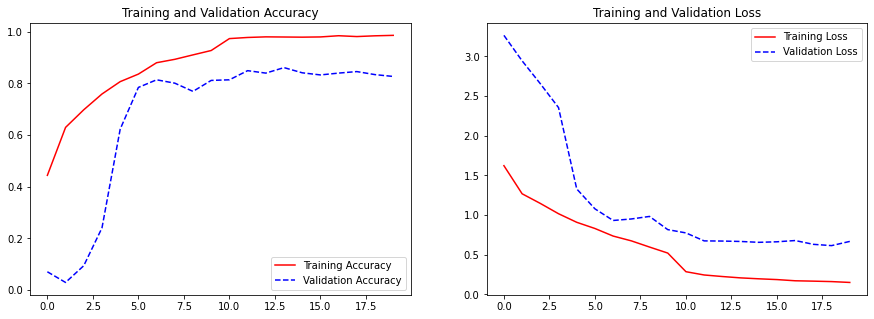

In [ ]:
plot_training(history_eff)

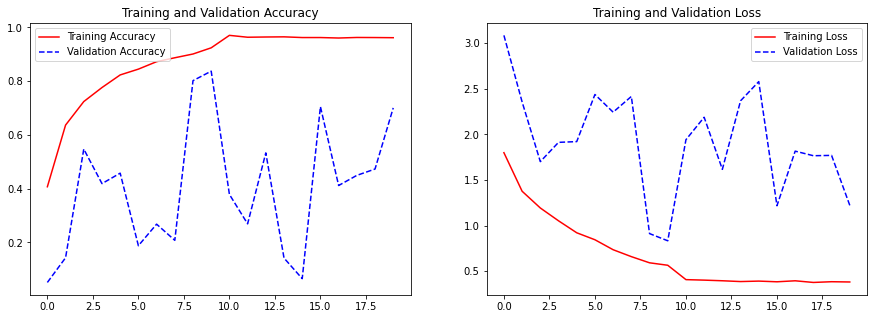

In [ ]:
# Prediction accuracy on train data
score = model_res.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

<ipython-input-43-fb7c4860b2ae>:2: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.

  score = model_res.evaluate_generator(train_generator, verbose=1)
216/216 [==============================] - 99s 460ms/step - loss: 0.2031 - accuracy: 0.9794

Prediction accuracy on train data = 0.9793844223022461

In [ ]:
score_eff = model_eff.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score_eff[1])

<ipython-input-44-06b1cbd90a70>:1: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.

  score_eff = model_eff.evaluate_generator(train_generator, verbose=1)
216/216 [==============================] - 96s 444ms/step - loss: 0.8725 - accuracy: 0.8397

Prediction accuracy on train data = 0.8397212624549866